## Import necessary modules


In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os, sys
os.chdir('drive/My Drive/Neural/SSM/Neural Analysis')

Mounted at /content/drive


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

sys.path.append('/content/drive/My Drive/Neural/SSM/Neural Analysis/ssm')
#sys.path.append('ssm')
import ssm

import numpy as np
import numpy.random as npr
npr.seed(0)
import random

import matplotlib.pyplot as plt
import os, datetime, yaml
from scipy import io as sio
from ssm.util import one_hot, find_permutation
import seaborn as sns
sns.set(palette="colorblind")

sns.set_style("white")
sns.set_context("talk")
sns.set_style('ticks',{"xtick.major.size":8,
"ytick.major.size":8})
from ssm.plots import gradient_cmap, white_to_color_cmap

color_names = [
    "purple",
    "red",
    "amber",
    "faded green",
    "windows blue",
    "orange"
    ]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

## Load or Generate Data 

In [3]:
mat = sio.loadmat('./chewie_CO_CS_BL_10212016_001_py_5ms')

In [4]:
LATENCY = 5
assert LATENCY in [5,25]
mult = 2.5 if LATENCY == 25 else 0.5
mat = sio.loadmat(f'./chewie_CO_CS_BL_10212016_001_py_{LATENCY}ms')

num_cells = {'pmd':mat['neural_data_PMd'][0,0].shape[0], 
             'm1': mat['neural_data_M1'][0,0].shape[0],
             'all': mat['neural_data_PMd'][0,0].shape[0] +  mat['neural_data_M1'][0,0].shape[0]}

num_trials = mat['neural_data_PMd'].shape[1]

kin=mat['kinematics']
go_time_rel = mat['go_time_rel']
move_time_rel = mat['move_time_rel']

## find when cue is on to align all trials
kin_dt = 0.01
cue_on_bin= [int(mat['go_time_rel'][0,i][0,0]/kin_dt/mult) for i in range(mat['go_time_rel'].shape[1])]
move_bin= [int(mat['move_time_rel'][0,i][0,0]/kin_dt/mult) for i in range(mat['move_time_rel'].shape[1])]

ys = {'pmd':[], 'm1':[], 'all':[]}
for trial in range(num_trials):
  ys['all'].append(np.concatenate([mat['neural_data_PMd'][0,trial].T,mat['neural_data_M1'][0,trial].T], axis = 1).astype(int))
  ys['pmd'].append((mat['neural_data_PMd'][0,trial].T).astype(int))
  ys['m1'].append((mat['neural_data_M1'][0,trial].T).astype(int))

(array([13., 33., 41., 30., 33., 38., 38., 31., 23.,  6.]),
 array([313. , 337.5, 362. , 386.5, 411. , 435.5, 460. , 484.5, 509. ,
        533.5, 558. ]),
 <a list of 10 Patch objects>)

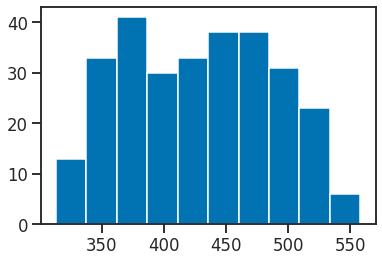

In [5]:
# TODO: What should I do here? 
plt.hist([y.shape[0] for y in ys['all']])

In [6]:
num_steps = max([y.shape[0] for y in ys['all']])
# ys_padded = {'all' :np.array([np.pad(ys['all'][i],((0,num_steps - ys['all'][i].shape[0]),(0,0),), constant_values = 0) for i in range(num_trials)]),
#              'm1': np.array([np.pad(ys['m1'][i],((0,num_steps - ys['m1'][i].shape[0]),(0,0),), constant_values = 0) for i in range(num_trials)]),
#              'pmd': np.array([np.pad(ys['pmd'][i],((0,num_steps - ys['pmd'][i].shape[0]),(0,0),), constant_values = 0) for i in range(num_trials)])}

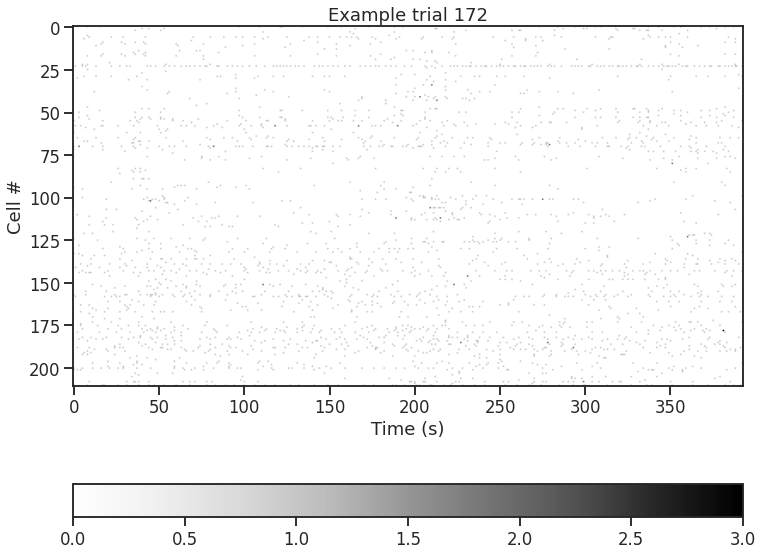

In [7]:
plt.figure(figsize = (12,12))
random_trial = np.random.randint(num_trials)
plt.imshow(ys['pmd'][random_trial].T, cmap=plt.cm.Greys)
plt.xlabel('Time (s)')
plt.ylabel('Cell #')
plt.colorbar(orientation='horizontal')
plt.title(f'Example trial {random_trial}');

## Output

In [8]:
factors = np.load('./output/lfads/master_run_5ms_m1/factors_m1_padded.npy', allow_pickle = True)
factors_nonpadded = np.load('./output/lfads/master_run_5ms_m1/factors_m1.npy', allow_pickle = True)

In [9]:
zhat_25ms = np.load('models/slds/m1/SLDS_m1_K=3_D=5_Transitions=sticky.npy', allow_pickle = True).tolist()['zhat']

Visualize across different K

In [ ]:
N_iters = 50
transitions = 'standard'
models = {K:np.load(f'models/arhmm/m1/ARHMM_K={K}_iters={N_iters}_transitions={transitions}_m1.npy', allow_pickle = True).tolist()['model'] for K in range(3,7)}

random_trials = list(range(num_trials))
random.shuffle(random_trials)
for i in random_trials[:50]:
  f, axarr = plt.subplots(2 + len(models),1, figsize = (8,8))
  f.tight_layout()
  if cue_on_bin[i] <= move_bin[i]:
    axarr[0].imshow([[1]*cue_on_bin[i] + [2] * (move_bin[i]-cue_on_bin[i]) + [3]*(factors_nonpadded[i].shape[0] - move_bin[i])] , aspect="auto")#, cmap=cmap, vmin=0, vmax=len(colors)-1)
  else:
    axarr[0].imshow([[1]*cue_on_bin[i] + [3]*(factors_nonpadded[i].shape[0] - cue_on_bin[i])] , aspect="auto")#, cmap=cmap, vmin=0, vmax=len(colors)-1)
  axarr[0].set_title(f'Trial {i} behaviors')
  axarr[1].imshow(zhat_25ms[i][None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
  axarr[1].set_title(f'25ms result')
  for j,K in enumerate(range(3,7)):
    inferred_states = models[K].most_likely_states(factors_nonpadded[i])
    axarr[j+2].imshow(inferred_states[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
    axarr[j+2].set_title(f'inferred states with K = {K}')
  plt.show()
  
  print("*"*100)

Visualize across different transitions

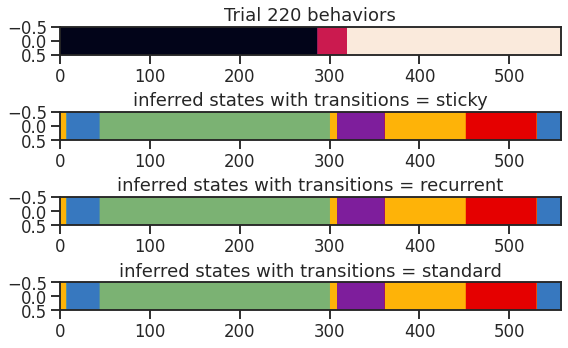

****************************************************************************************************


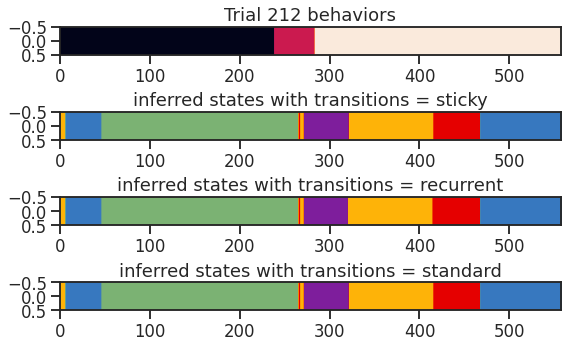

****************************************************************************************************


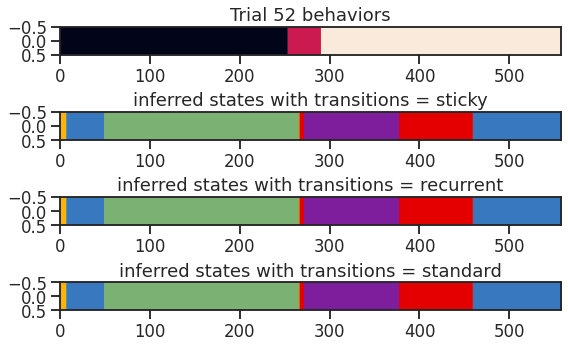

****************************************************************************************************


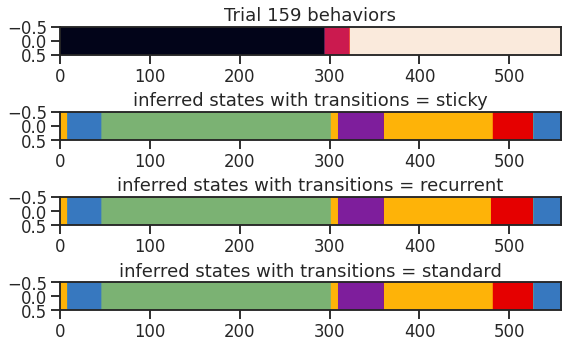

****************************************************************************************************


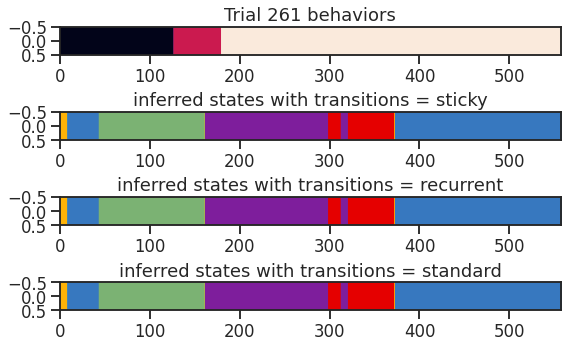

****************************************************************************************************


In [10]:
N_iters = 50
K = 5
transitions_list = ['sticky', 'recurrent', 'standard']
models = {transitions:np.load(f'models/arhmm/m1/ARHMM_K={K}_iters={N_iters}_transitions={transitions}_m1.npy', allow_pickle = True).tolist()['model'] for transitions in transitions_list}

random_trials = list(range(num_trials))
random.shuffle(random_trials)
for i in random_trials[:5]:
  f, axarr = plt.subplots(1 + len(models),1, figsize = (8,5))
  f.tight_layout()
  axarr[0].imshow([[1]*cue_on_bin[i] + [2] * (move_bin[i]-cue_on_bin[i]) + [3]*(num_steps - move_bin[i])] , aspect="auto")#, cmap=cmap, vmin=0, vmax=len(colors)-1)
  axarr[0].set_title(f'Trial {i} behaviors')
  for j,transitions in enumerate(transitions_list):
    inferred_states = models[transitions].most_likely_states(factors[i])
    axarr[j+1].imshow(inferred_states[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
    axarr[j+1].set_title(f'inferred states with transitions = {transitions}')
  plt.show()
  
  print("*"*100)

Check behaviors

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  This is separate from the ipykernel package so we can avoid doing imports until


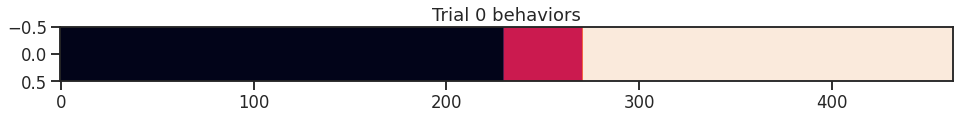

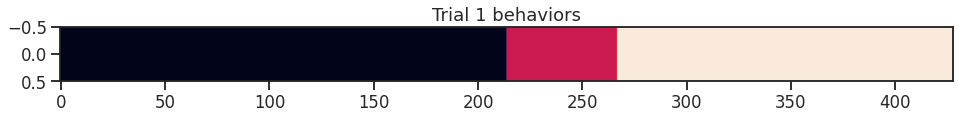

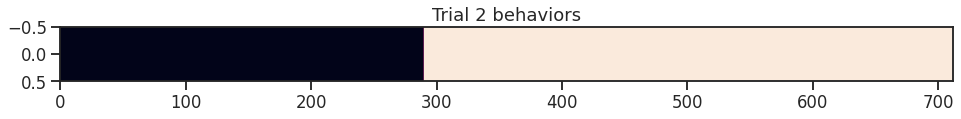

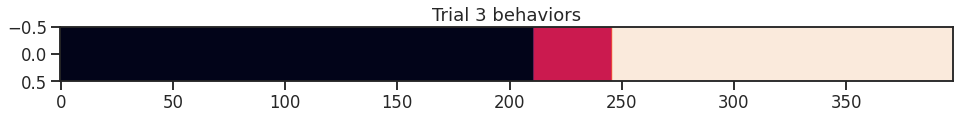

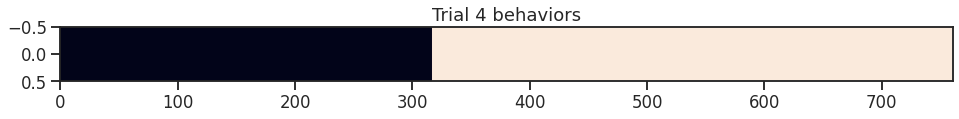

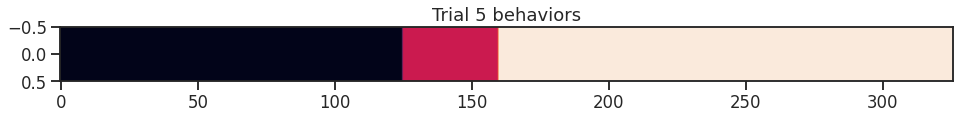

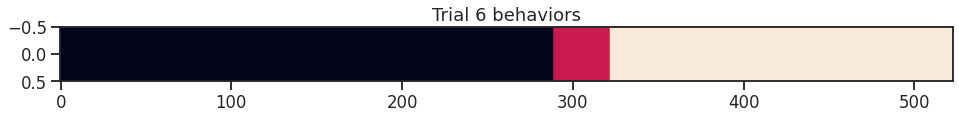

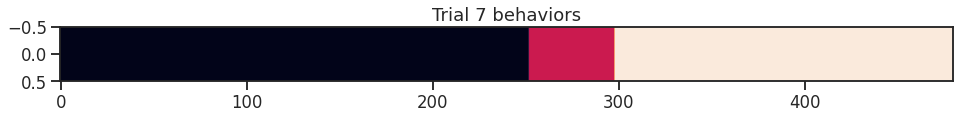

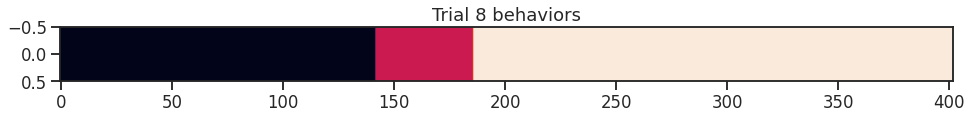

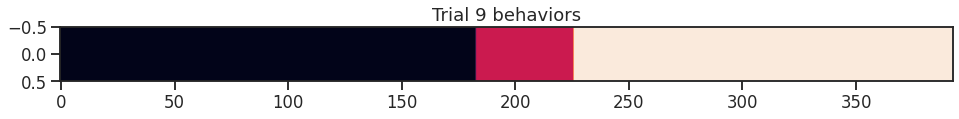

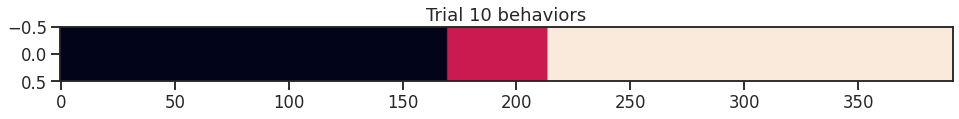

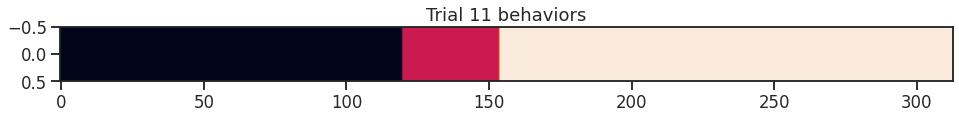

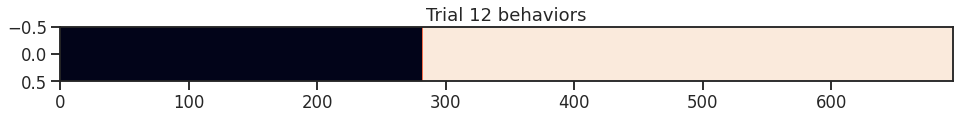

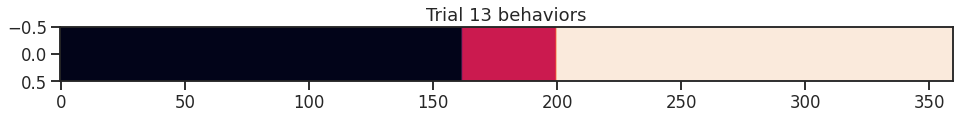

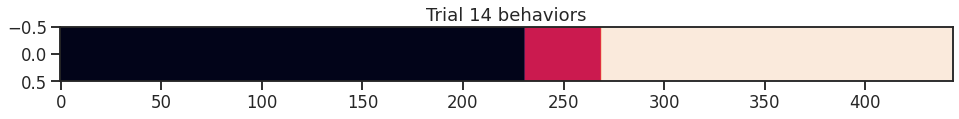

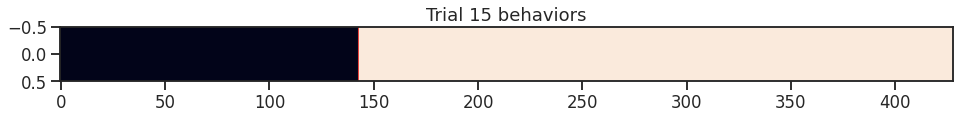

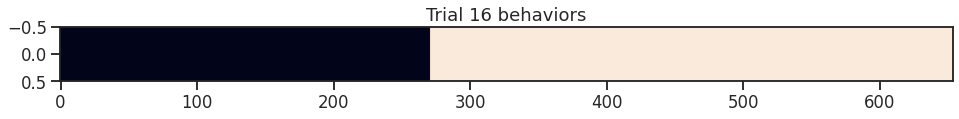

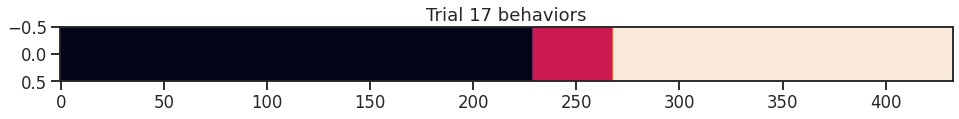

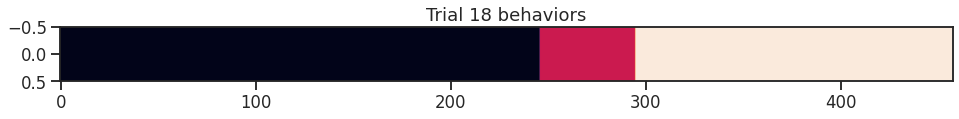

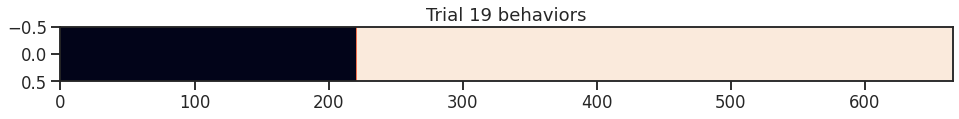

In [116]:
for i in range(20):
  f, axarr = plt.subplots(1,1, figsize = (16,1))
  f.tight_layout()
  axarr.imshow([[1]*cue_on_bin[i] + [2] * (move_bin[i]-cue_on_bin[i]) + [3]*(factors_nonpadded[i].shape[0] - move_bin[i])] , aspect="auto")#, cmap=cmap, vmin=0, vmax=len(colors)-1)
  axarr.set_title(f'Trial {i} behaviors')
  plt.show()
  

In [117]:
cue_on_bin[2]

290

In [118]:
move_bin[2]

58